In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from find_image import FindImage
import os
from dotenv import load_dotenv
import json 

2023-10-22 20:57:41.832311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 20:57:41.832335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 20:57:41.832358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 20:57:41.837558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 20:57:42.644615: W tensorflow/compiler/

In [2]:
load_dotenv()

True

In [3]:
s3 = FindImage(True, bucket_name=os.getenv("BUCKET_S3"), resource_name="s3")

In [4]:
# Ajustar o caminho para que o jupyter tenha permissão de escrita na pagina
# s3.download_images_training(os.getenv("IMGS_TRAINING"), "pets")

In [3]:
train_dir = '/home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/imgs_training/'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalização das intensidades dos pixels
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Tamanho das imagens (ajuste conforme necessário)
    batch_size=BATCH_SIZE, # Em quantos pacotes/partes eu divido meu dataset 
    class_mode='categorical'  # Modo categórico para múltiplas classes
)

Found 60 images belonging to 15 classes.


In [6]:
model = models.Sequential()

#CNN
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#RNA
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))
model.compile(optimizer = Adam(learning_rate=0.0001, weight_decay=0.001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

2023-10-22 20:57:58.247216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 20:57:58.268996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-22 20:57:58.269225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='model_recognator_v2.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1,
                                  monitor='loss')

# EarlyStopping
early_stop = EarlyStopping(monitor='loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

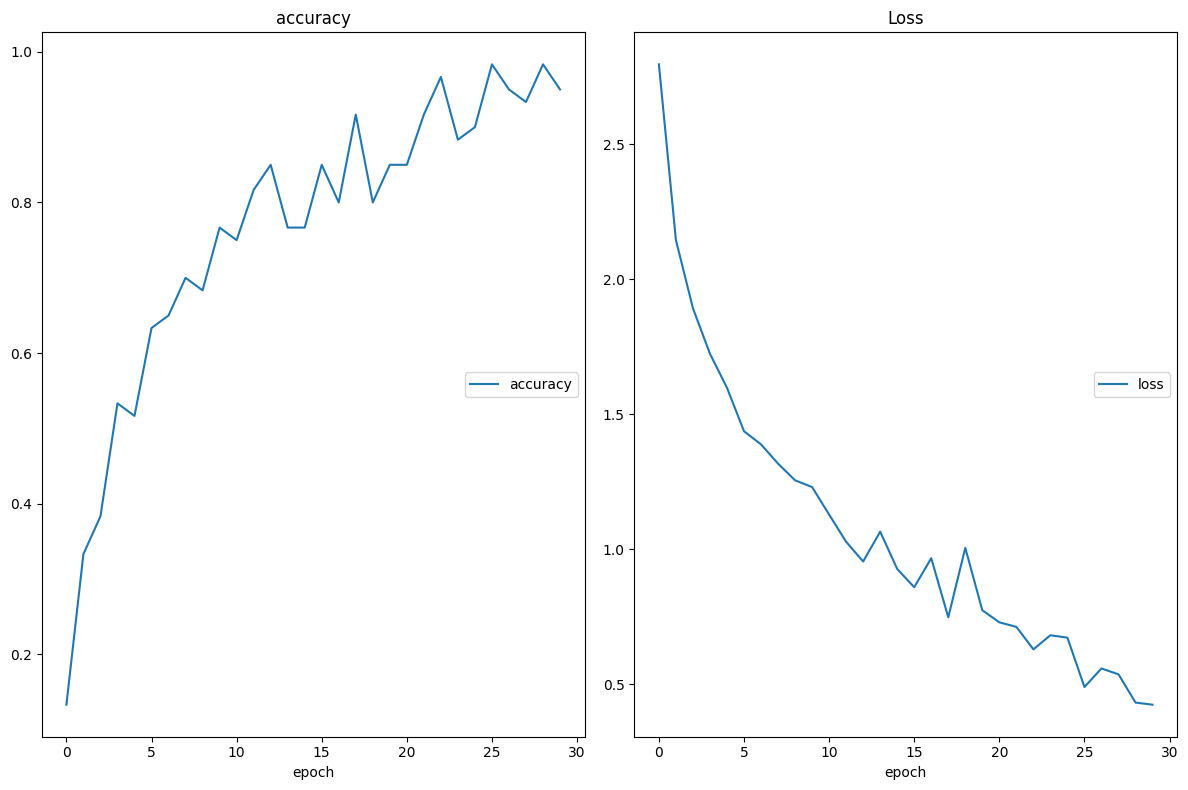

accuracy
	accuracy         	 (min:    0.133, max:    0.983, cur:    0.950)
Loss
	loss             	 (min:    0.423, max:    2.795, cur:    0.423)
2/2 [==============================] - 16s 16s/step - loss: 0.4235 - accuracy: 0.9500


In [8]:
model.fit(train_generator,
  batch_size=BATCH_SIZE,
  callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
  verbose=1,
  epochs=30)

In [9]:
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

['6531dfe2ebaec4837b4f1f9c', '6531e147ebaec4837b4f1fb6', '6531e1d1ebaec4837b4f1fcb', '6531e32aebaec4837b4f1fe6', '6531e434ebaec4837b4f2001', '6531e4a1ebaec4837b4f2022', '6531e520ebaec4837b4f203b', '6531e677ebaec4837b4f2064', '6531e76febaec4837b4f207f', '6531e7deebaec4837b4f2096', '6531e84cebaec4837b4f20ab', '6531ea71ebaec4837b4f20c5', '6531ead5ebaec4837b4f20da', '6531eb3aebaec4837b4f20ef', '6531f14e6cf94bd6b850ea90']


In [10]:
dict_class_labels = {}
for index, class_label in enumerate(class_labels):
  dict_class_labels[index] = class_label

print(dict_class_labels)

{0: '6531dfe2ebaec4837b4f1f9c', 1: '6531e147ebaec4837b4f1fb6', 2: '6531e1d1ebaec4837b4f1fcb', 3: '6531e32aebaec4837b4f1fe6', 4: '6531e434ebaec4837b4f2001', 5: '6531e4a1ebaec4837b4f2022', 6: '6531e520ebaec4837b4f203b', 7: '6531e677ebaec4837b4f2064', 8: '6531e76febaec4837b4f207f', 9: '6531e7deebaec4837b4f2096', 10: '6531e84cebaec4837b4f20ab', 11: '6531ea71ebaec4837b4f20c5', 12: '6531ead5ebaec4837b4f20da', 13: '6531eb3aebaec4837b4f20ef', 14: '6531f14e6cf94bd6b850ea90'}


In [11]:
class_names_file = 'class_names.json'
with open(class_names_file, 'w') as file:
    json.dump(dict_class_labels, file)

In [12]:
model.load_weights('/home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/model_recognator_v2.weights.best.hdf5')

In [16]:
from tensorflow.keras.preprocessing import image

test_image_path = '/home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/imgs_test/gatinha.jpeg'

img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalização

prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)
print(prediction)

1/1 [==============================] - 0s 22ms/step
6531dfe2ebaec4837b4f1f9c
[[0.16641952 0.14206734 0.04060488 0.02821136 0.07365469 0.06621681
  0.11378519 0.01884739 0.02733233 0.05858061 0.09947745 0.02071367
  0.06692476 0.04538563 0.0317784 ]]


In [18]:
model.save('/home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/modelv2')

INFO:tensorflow:Assets written to: /home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/modelv2/assets


INFO:tensorflow:Assets written to: /home/patrick/SPTECH/TCC/grupo11-4cco-tcc/src/inteligencia_artificial/modelv2/assets
